In [86]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import plotly.figure_factory as ff
from IPython.display import HTML, display
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import math
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# from importlib import reload
from imp import reload
import itertools
import warnings
warnings.filterwarnings('ignore')

## Preprocess data

In [87]:
PATH = 'rainfall_data_1901_to_2002.xlsx'

In [88]:
data = pd.read_excel(PATH)

In [89]:
data = data.drop(columns='vlookup')
data = data[data['Year'].notnull()]
data['Year'] = data.Year.astype('int')
data.index = range(len(data))
data.head()

,State,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,Andhra Pradesh,Adilabad,1901,6.725,10.488,23.288,35.560,23.119,115.546,294.119,276.865,181.615,47.310,1.339,0.000
1,Andhra Pradesh,Adilabad,1902,0.420,0.000,0.388,6.070,3.331,45.960,233.973,167.971,198.177,26.447,35.083,11.222
2,Andhra Pradesh,Adilabad,1903,6.643,1.956,0.173,4.551,33.348,132.078,436.611,334.544,226.037,138.818,14.095,8.823
3,Andhra Pradesh,Adilabad,1904,0.054,0.121,11.446,0.017,16.900,131.048,160.694,81.865,251.577,110.391,0.146,0.130
4,Andhra Pradesh,Adilabad,1905,0.589,2.293,8.252,35.020,17.569,79.937,96.331,313.522,361.697,4.950,0.146,0.000


In [90]:
m_data = data[data['State'] == 'Maharashtra']
m_data = m_data.drop(columns='State')
m_data.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000


In [91]:
districts = m_data.District.unique()
years = list(range(1901, 2003))
months = data.columns[3:]
year_month = [str(year) + '_' + month for year in years for month in months]
dates = pd.date_range(start='1901-01', freq='MS', periods=len(years)*12)

In [92]:
maharashtra_data = pd.DataFrame({'Year_Month': year_month})
maharashtra_data['Date'] = dates
maharashtra_data[['Year', 'Month']] = maharashtra_data['Year_Month'].str.split('_', n=1, expand=True)
maharashtra_data = maharashtra_data.drop(columns=['Year_Month'])

for district in districts:
    df = m_data[m_data.District == district].drop(columns=['District', 'Year'])
    df = df.as_matrix().reshape((len(years) * len(months), 1))[:,0]
    maharashtra_data[district] = df

#maharashtra_data = maharashtra_data.rename(columns={'Gadchiroli': 'Garhchiroli'})
maharashtra_data.head()

,Date,Year,Month,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
0,1901-01-01,1901,Jan,2.510,34.202,35.651,10.922,23.397,16.647,31.455,...,5.063,15.500,33.207,0.922,0.138,0.197,4.496,45.050,32.485,22.031
1,1901-02-01,1901,Feb,11.489,1.099,6.822,4.362,63.844,1.916,0.823,...,1.609,2.784,4.997,7.195,0.537,0.525,3.667,28.220,3.607,16.198
2,1901-03-01,1901,Mar,11.325,30.002,36.103,25.161,33.563,27.287,28.448,...,11.196,11.333,31.625,5.105,13.090,9.566,10.330,26.398,26.557,29.318
3,1901-04-01,1901,Apr,33.931,10.248,10.636,12.714,61.560,33.211,13.902,...,7.838,34.814,41.941,35.949,50.077,30.110,59.854,29.228,18.127,30.521
4,1901-05-01,1901,May,30.401,2.891,4.173,34.244,13.665,59.027,9.397,...,7.475,52.792,31.794,36.650,78.994,65.226,50.892,8.619,6.700,13.193


## Correlation matrix - Districts

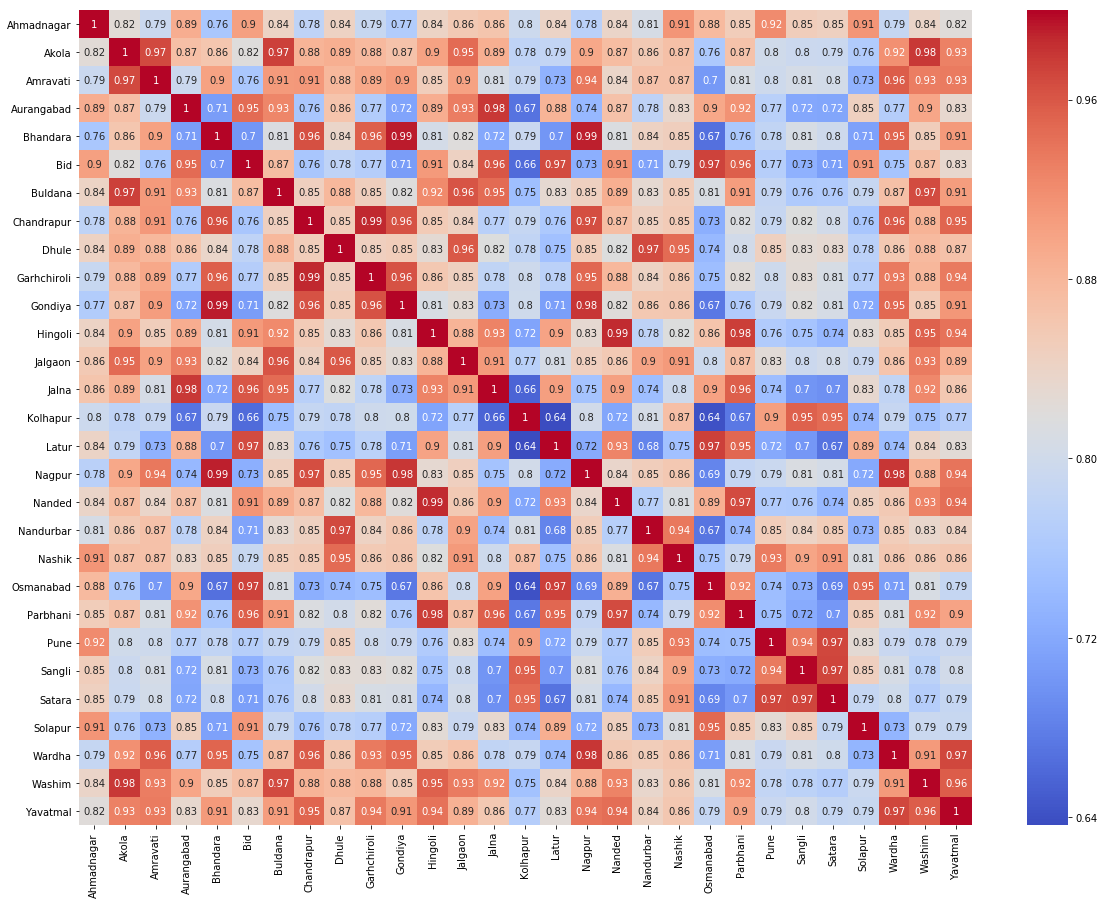

In [93]:
corr_matrix = maharashtra_data.drop(columns=['Year', 'Month']).corr().abs()
plt.figure(figsize=(20,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Highly correlated districts

In [94]:
def return_highly_correlated(corr_matrix, corr_coef):
    district_corr = corr_matrix.abs().unstack().sort_values().drop_duplicates()
    tuples = district_corr[(district_corr > corr_coef) & (district_corr != 1.0)]
    levels = tuples.index.levels[0]
    labels = tuples.index.labels

    high_corr_districts = []
    for i in range(len(labels[0])):
        high_corr_districts.append([levels[labels[0][i]], levels[labels[1][i]], tuples[i]])
    high_corr_districts = np.array(high_corr_districts)
    df = pd.DataFrame({'District1': high_corr_districts[:, 0], 
                      'District2': high_corr_districts[:, 1],
                      'Correlation_coefficient': high_corr_districts[:, 2]},
                     columns = ['District1', 'District2', 'Correlation_coefficient'])
    return df

In [95]:
high_corr_districts = return_highly_correlated(corr_matrix, 0.98)
high_corr_districts

,District1,District2,Correlation_coefficient
0,Nagpur,Gondiya,0.9805330709528167
1,Nagpur,Wardha,0.9811563634226902
2,Nanded,Hingoli,0.9858166679818119
3,Chandrapur,Garhchiroli,0.9885737788804028
4,Nagpur,Bhandara,0.9907760645844106
5,Bhandara,Gondiya,0.9922307205938624


## Precipitation data of the district "Pune"

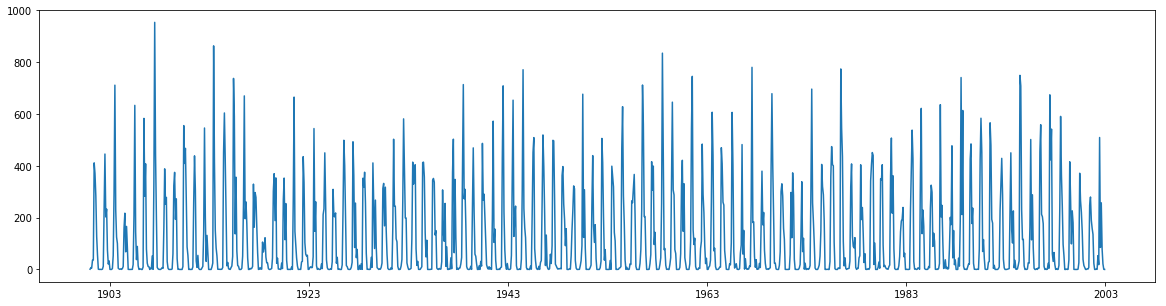

In [96]:
plt.figure(figsize=(20,5))
plt.plot(maharashtra_data.Date, maharashtra_data.Pune)

## Plot the districts with heavy rainfall over all years(>700|800mm)

In [97]:
high_rainfall = {}
districts = maharashtra_data.columns[3:]
for district in districts:
    count = len(maharashtra_data[maharashtra_data[district]>=800])
    if count != 0:
        high_rainfall[district] = count
high_rainfall

{'Kolhapur': 49,
 'Nandurbar': 10,
 'Nashik': 1,
 'Pune': 3,
 'Sangli': 1,
 'Satara': 25}

## Boxplot - District wise precipitation across all years

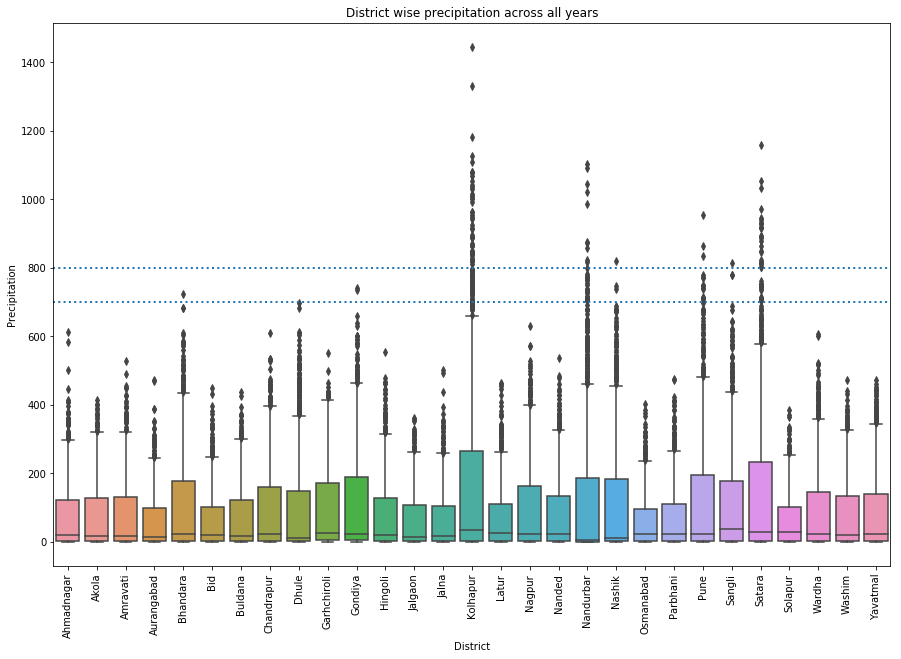

In [98]:
matrix = maharashtra_data.drop(columns=['Date', 'Year', 'Month'])

plt.figure(figsize=(15,10))
g = sns.boxplot(x="variable", y="value", data=pd.melt(matrix))
labels = g.get_xticklabels()
g.set_xticklabels(labels, rotation=90)
g.set_xlabel('District')
g.set_ylabel('Precipitation')
g.set_title('District wise precipitation across all years')
plt.axhline(y=700, linewidth=2, linestyle='dotted')
plt.axhline(y=800, linewidth=2, linestyle='dotted')

- In district 'Kolhapur', the precipitation is above 800mm for many times. It says that the rainfall was heavy in Kolhapur district.

## Yearly average precipitation data across all districts in Maharashtra

In [99]:
m_data_copy = maharashtra_data.copy()
m_data_copy = m_data_copy.drop(columns=['Date', 'Year', 'Month'])
m_data_copy = m_data_copy.groupby(np.arange(len(df))//12).mean()
columns = m_data_copy.columns
columns = columns.insert(0, 'Year')
m_data_copy['Year'] = maharashtra_data.Year.unique()
m_data_copy = m_data_copy.reindex(columns=columns)
m_data_copy.set_index('Year', inplace=True)

In [100]:
m_data_copy.head()

,Ahmadnagar,Akola,Amravati,Aurangabad,Bhandara,Bid,Buldana,Chandrapur,Dhule,Garhchiroli,...,Nashik,Osmanabad,Parbhani,Pune,Sangli,Satara,Solapur,Wardha,Washim,Yavatmal
Year,,,,,,,,,,,,,,,,,,,,,
1901,63.092750,77.823333,73.880833,62.966417,89.942500,68.990750,82.473833,92.038500,65.832667,82.867167,...,82.748167,56.653750,72.188500,111.361167,93.724583,131.658083,55.418750,85.357167,76.065333,82.455833
1902,70.940333,59.357500,61.660417,57.995167,67.120917,58.366167,56.106333,63.641167,93.626833,64.669333,...,108.657333,54.276250,59.543417,105.194917,93.180500,127.642583,52.421833,67.705750,62.795333,64.140083
1903,97.554083,78.115750,78.562250,65.851333,131.699667,74.999000,75.238000,112.471250,121.145583,113.153167,...,125.389917,87.275417,86.754917,127.237417,116.895250,130.759500,85.031583,97.724917,89.132250,101.637750
1904,48.702417,58.301917,48.570083,60.179417,77.639417,57.015417,64.512667,66.476000,65.572833,71.484583,...,77.788500,50.810000,60.305917,59.527833,69.020917,80.311583,43.898083,59.393333,65.820500,61.974667
1905,46.729833,56.520417,66.528167,37.807083,115.219833,36.920667,54.126833,93.275583,66.059417,95.537417,...,74.322667,38.655583,45.336000,95.595917,69.095750,111.762833,37.047167,83.216500,54.317333,69.244500


## Monthly rainfall for each year in Maharashtra

In [101]:
m_data_copy = m_data.copy()
m_data_copy['Jan-Feb'] = m_data_copy['Jan'] + m_data_copy['Feb']
m_data_copy['Mar-May'] = m_data_copy['Mar'] + m_data_copy['Apr'] + m_data_copy['May']
m_data_copy['Jun-Sep'] = m_data_copy['Jun'] + m_data_copy['Jul'] + m_data_copy['Aug'] + m_data_copy['Sep']
m_data_copy['Oct-Dec'] = m_data_copy['Oct'] + m_data_copy['Nov'] + m_data_copy['Dec']
m_data_copy['Annual'] = m_data_copy['Jan-Feb'] + m_data_copy['Mar-May'] + m_data_copy['Jun-Sep'] + m_data_copy['Oct-Dec']
m_data_copy.head()

,District,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec,Annual
26826,Ahmadnagar,1901,2.510,11.489,11.325,33.931,30.401,262.971,162.397,120.152,58.708,62.633,0.596,0.000,13.999,75.657,604.228,63.229,757.113
26827,Ahmadnagar,1902,0.603,0.000,0.003,1.340,6.338,90.293,223.483,101.852,297.212,61.453,41.992,26.715,0.603,7.681,712.840,130.160,851.284
26828,Ahmadnagar,1903,0.227,0.000,0.000,2.602,69.076,182.652,500.983,156.236,164.433,88.419,2.022,3.999,0.227,71.678,1004.304,94.440,1170.649
26829,Ahmadnagar,1904,0.937,1.126,1.051,2.378,4.365,120.658,117.058,38.470,225.726,72.389,0.271,0.000,2.063,7.794,501.912,72.660,584.429
26830,Ahmadnagar,1905,0.000,0.622,0.000,0.452,4.115,114.385,197.696,116.061,54.338,66.508,6.581,0.000,0.622,4.567,482.480,73.089,560.758


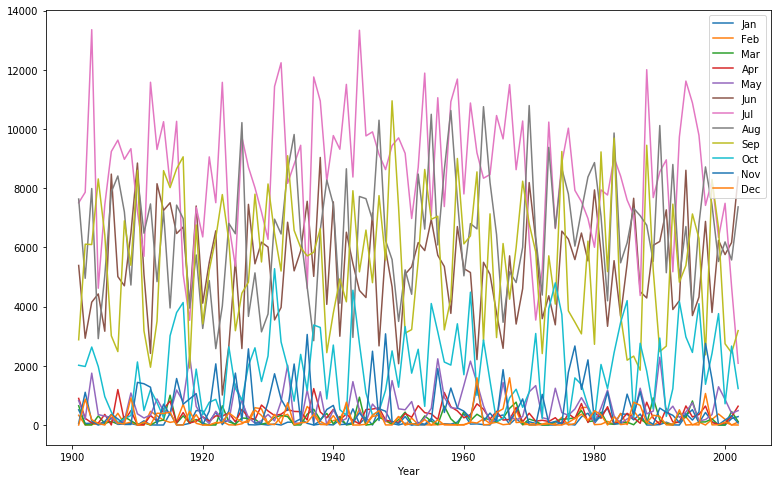

In [102]:
months = list(m_data.columns[1:])
m_data_copy[months].groupby("Year").sum().plot(figsize=(13,8))

## Seasonal rainfall for each year in Maharashtra

In [103]:
seasonal_data = m_data_copy[['Year','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("Year").sum()

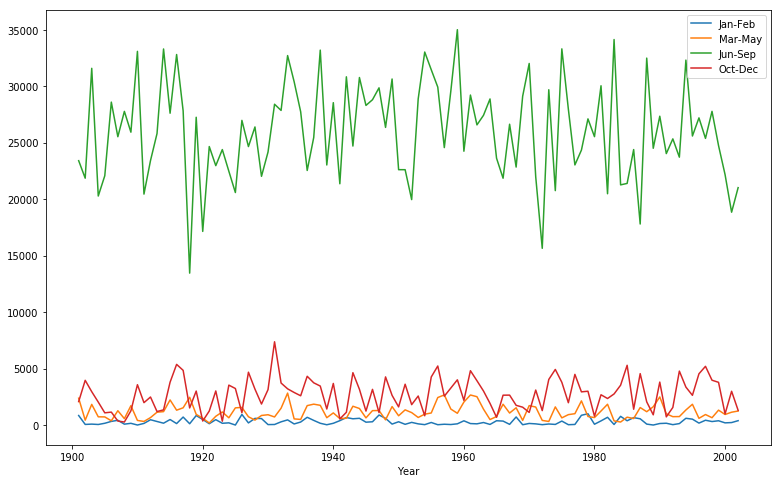

In [104]:
seasonal_data.plot(figsize=(13,8))

## District wise Seasonal rainfall across all years

In [105]:
seasonal_district_data = m_data_copy[['District','Jan-Feb', 'Mar-May', 'Jun-Sep', 'Oct-Dec']].groupby("District").sum()
seasonal_district_data.head()

,Jan-Feb,Mar-May,Jun-Sep,Oct-Dec
District,,,,
Ahmadnagar,249.735,4052.170,72472.375,9793.123
Akola,1396.348,2430.082,71598.467,9373.896
Amravati,1570.125,2631.008,76188.207,8760.707
Aurangabad,374.951,3030.083,56120.789,9403.228
Bhandara,3109.308,4954.334,111808.461,7086.156


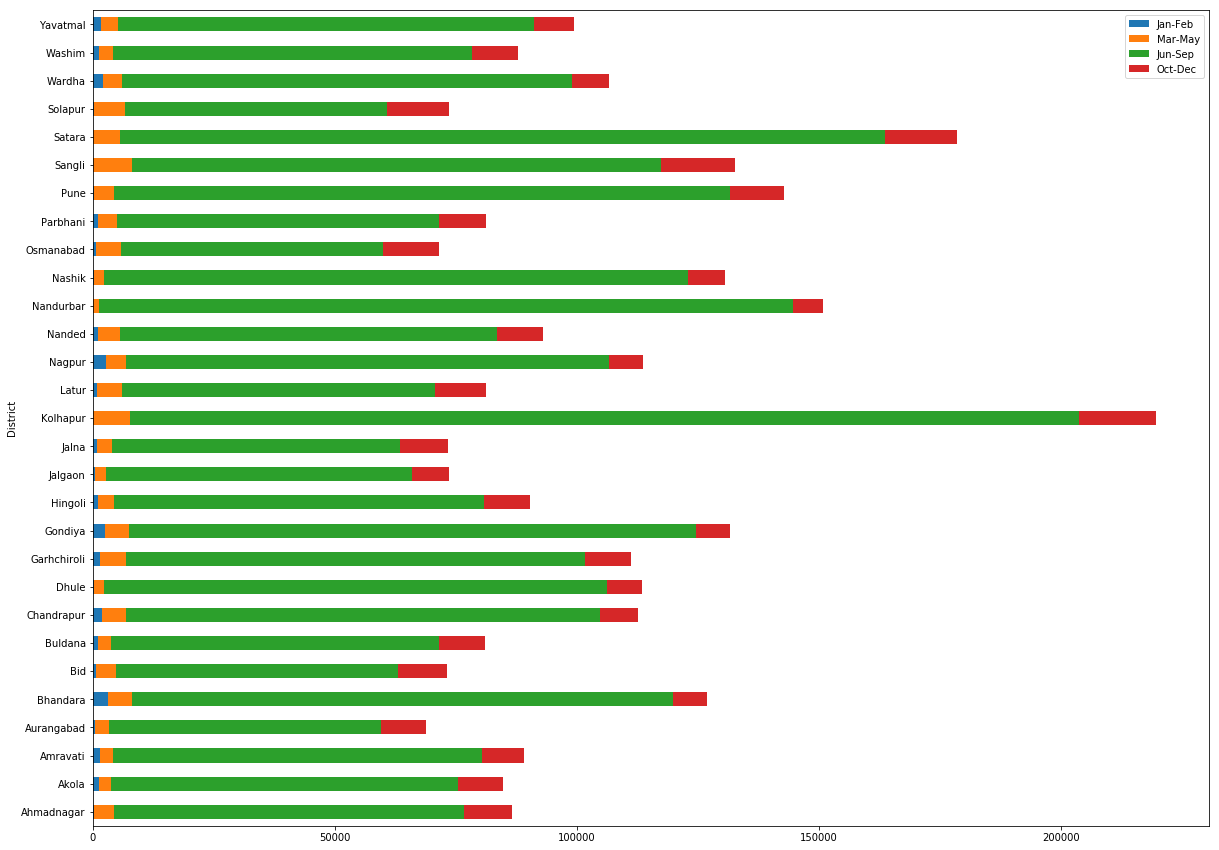

In [106]:
seasonal_district_data.plot.barh(stacked=True,figsize=(20,15));

## District wise Monthly mean precipitation across all years

In [107]:
columns = list(m_data.columns[2:])
columns.insert(0, m_data.columns[0])
monthly_mean_data = m_data_copy[columns].groupby("District").mean()
monthly_mean_data.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
District,,,,,,,,,,,,
Ahmadnagar,0.764765,1.683618,2.516147,10.872980,26.338029,165.464843,233.050088,146.425843,165.572706,66.866951,23.717127,5.426931
Akola,8.296598,5.393088,8.215549,5.283069,10.325716,146.805363,216.788843,183.560373,154.791176,58.458794,23.729500,9.712647
Amravati,9.114353,6.279029,11.095029,5.637853,9.061314,145.434049,250.601422,205.358167,145.549569,53.563343,22.682284,9.643657
Aurangabad,2.308088,1.367902,3.273343,6.156657,20.276696,111.857392,149.430108,105.088363,183.827951,53.443627,30.078951,8.665931
Bhandara,10.836088,19.647324,15.275010,17.592314,15.704578,184.951412,373.926020,338.800657,198.483294,50.267510,9.901167,9.303441


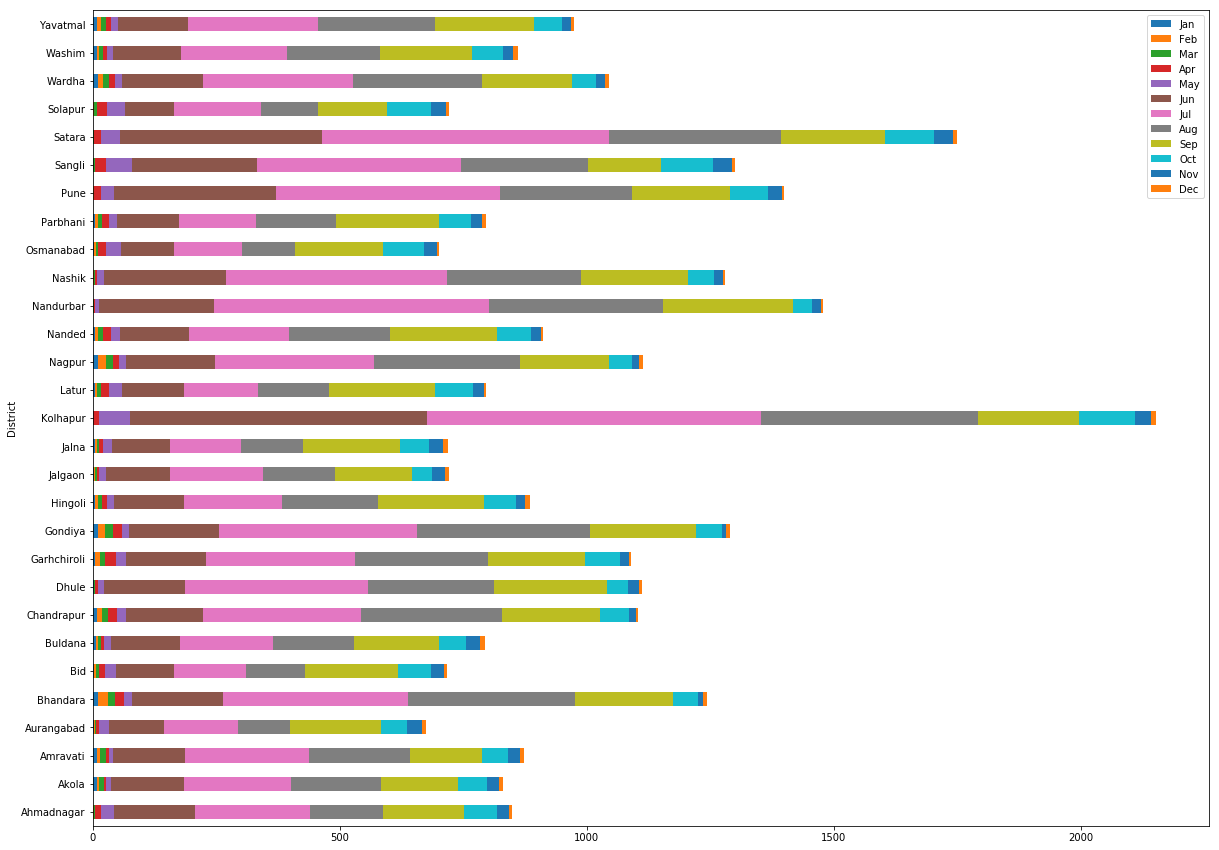

In [108]:
monthly_mean_data.plot.barh(stacked=True,figsize=(20,15));

## Annual rainfall in Maharshtra

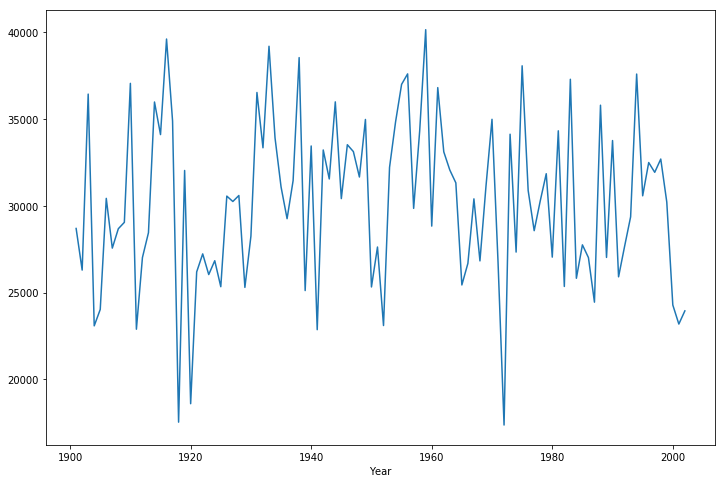

In [109]:
Annual_rainfall = m_data_copy.groupby('Year').sum()['Annual']
Annual_rainfall.plot(figsize=(12,8))

## Best method for each district

In [110]:
maharashtra_data.Ahmadnagar.head()

0     2.510
1    11.489
2    11.325
3    33.931
4    30.401
Name: Ahmadnagar, dtype: float64

In [111]:
dates

DatetimeIndex(['1901-01-01', '1901-02-01', '1901-03-01', '1901-04-01',
               '1901-05-01', '1901-06-01', '1901-07-01', '1901-08-01',
               '1901-09-01', '1901-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', length=1224, freq='MS')

In [112]:
rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[:-60]})
rainfall_data.index = dates[:-60]
rainfall_data.tail()

,Precipitation
1997-08-01,257.381
1997-09-01,45.384
1997-10-01,28.709
1997-11-01,85.942
1997-12-01,22.876


In [113]:
test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data.Ahmadnagar[-60:]})
test_rainfall_data.index = dates[-60:]
test_rainfall_data.head()

,Precipitation
1998-01-01,0.125
1998-02-01,2.136
1998-03-01,0.721
1998-04-01,0.365
1998-05-01,13.475


In [114]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(rainfall_data)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [115]:
import Artificial_Neural_Networks as ANN

In [116]:
future_steps = 60
STORAGE_FOLDER = 'State_predictions/'
if not os.path.exists(STORAGE_FOLDER):
    os.makedirs(STORAGE_FOLDER)

parameters_FNN = [[3,6,8,10,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_FNN = [[12], [4], [1], [50], [20], [future_steps]]

# time_lagged_points, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_TLNN = [[[1,2,3,11,12], [1,2,3,4,11,12], [1,2,3,4,5,6,10,11,12]], [3,4,5,6], [1], [300], [20], [future_steps]]
#parameters_TLNN = [[[1,2,3,4,5,6,10,11,12]], [4], [1], [30], [20], [future_steps]]

# seasonal_period, hidden_nodes, epochs, batch_size, future_steps
parameters_SANN = [[12], [3,4,5,6], [300], [20], [future_steps]]
#parameters_SANN = [[12], [3], [50], [20], [future_steps]]

# look_back, hidden_nodes, output_nodes, epochs, batch_size, future_steps
parameters_LSTM = [[6,8,10,11,12], [4,5,6], [1], [300], [20], [future_steps]]
#parameters_LSTM = [[12], [4], [1], [30], [20], [future_steps]]

In [117]:
# RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
#                     parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, STORAGE_FOLDER)

In [118]:
# ANN.save_RMSE_info(RMSE_info)

In [119]:
districts[23:]

Index(['Sangli', 'Satara', 'Solapur', 'Wardha', 'Washim', 'Yavatmal'], dtype='object')

In [120]:
# for district in districts[23:]:
#     print(district)
    
#     rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][:-60]})
#     rainfall_data.index = dates[:-60]
    
#     test_rainfall_data = pd.DataFrame({'Precipitation': maharashtra_data[district][-60:]})
#     test_rainfall_data.index = dates[-60:]
    
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaler.fit(rainfall_data)
    
#     output_folder = STORAGE_FOLDER + district + '/'
#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)
    
#     ANN = reload(ANN)
#     RMSE_info = ANN.compare_ANN_methods(rainfall_data, test_rainfall_data, scaler, 
#                     parameters_FNN, parameters_TLNN, parameters_SANN, parameters_LSTM, future_steps, output_folder)

#     ANN = reload(ANN)
#     ANN.save_RMSE_info(output_folder, RMSE_info)

In [121]:
#ANN.save_RMSE_info(output_folder, RMSE_info)

In [124]:
m_data_copy = m_data.drop(columns={'District','Year'})
max_value = m_data_copy.values.max()
min_value = m_data_copy.values.min()
print(max_value,min_value)

1443.526 0.0


In [125]:
# year_precipation = pd.DataFrame({'Precipitation': maharashtra_data.ix[0][3:]})
# year_precipation.index = maharashtra_data.ix[0].index[3:]
# year_precipation.head()

In [126]:
# num_colors = 9
# values = year_precipation['Precipitation'].astype(float)
# cm = plt.get_cmap('rainbow')
# # rainbow, spring, PuRd, plasma
# scheme = [cm(i / num_colors) for i in range(num_colors)]
# # bins = np.linspace(values.min(), values.max(), num_colors)
# bins = np.linspace(min_value,max_value, num_colors)
# year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
# year_precipation.sort_values('bin', ascending=False).head()

In [127]:
# fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111)

# map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

# map.drawmapboundary(fill_color='white')
# map.fillcontinents(color='white',lake_color='white')
# #map.drawcoastlines()

# map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

# for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
#     if(info['NAME_1'] == 'Maharashtra'):
#         x, y = zip(*shape) 
#         map.plot(x, y, marker=None, color='black')
        
#         district = info['NAME_2']
#         if district not in year_precipation.index:
#             color = '#dddddd'
#         else:
#             color = scheme[year_precipation.ix[district]['bin']]
#             color = '#ffffff'
#             patches = [Polygon(np.array(shape), True)]
#             pc = PatchCollection(patches)
#             pc.set_facecolor(color)
#             ax.add_collection(pc)
#     else:
#         color = '#dddddd'

# plt.show()

In [128]:
# fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111, frame_on=False)

# map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

# map.drawmapboundary(fill_color='white')
# map.fillcontinents(color='white',lake_color='white')
# # map.drawcoastlines()

# map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

# patches   = []
# facecolor_array = []

# for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
#     if(info['NAME_1'] == 'Maharashtra'):
#         x, y = zip(*shape) 
#         map.plot(x, y, marker=None, color='black')
        
#         district = info['NAME_2']
#         if district not in year_precipation.index:
#             color = '#dddddd'
#         else:
#             color = scheme[year_precipation.ix[district]['bin']]
#             patches.append( Polygon(np.array(shape), True))
#             facecolor_array.append(color)
#     else:
#         color = '#dddddd'

# ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    
# #ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
# ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
# cmap = matplotlib.colors.ListedColormap(scheme)
# cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
# cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# plt.show()

In [129]:
latlon_data = pd.read_csv("district_latlon.csv") 
latlon_data = latlon_data.drop(latlon_data.columns[latlon_data.columns.str.contains('unnamed',case = False)],axis = 1)
latlon_data.shape

(29, 4)

In [130]:
# num_colors = 9
# values = year_precipation['Precipitation'].astype(float)
# cm = plt.get_cmap('rainbow')
# # rainbow, spring, PuRd, plasma
# scheme = [cm(i / num_colors) for i in range(num_colors)]
# # bins = np.linspace(values.min(), values.max(), num_colors)
# bins = np.linspace(min_value,max_value, num_colors)
# year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
# year_precipation.sort_values('bin', ascending=False).head()

In [131]:
# fig = plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111, frame_on=False)

# map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

# map.drawmapboundary(fill_color='white')
# map.fillcontinents(color='white',lake_color='white')
# # map.drawcoastlines()

# map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

# patches   = []
# facecolor_array = []

# for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
#     if(info['NAME_1'] == 'Maharashtra'):
#         x, y = zip(*shape) 
#         map.plot(x, y, marker=None, color='black')
        
#         district = info['NAME_2']
#         if district not in year_precipation.index:
#             color = '#dddddd'
#         else:
#             color = scheme[year_precipation.ix[district]['bin']]
#             patches.append( Polygon(np.array(shape), True))
#             facecolor_array.append(color)
#     else:
#         color = '#dddddd'

# ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
# ax.set_title("Maharashtra Map")    

# lat = latlon_data['lat'].tolist()
# lon = latlon_data['lon'].tolist()
# label_dist = latlon_data['district'].tolist()

# X,Y = map(lon,lat)
# ax.scatter(X,Y)
# for i, (x, y) in enumerate(zip(X, Y), start=0):
#     ax.annotate(label_dist[i], (x,y), xytext=(0,0), textcoords='offset points',fontsize=15,color='w',arrowprops=dict(facecolor='white', shrink=0.05))

# #ax.axhspan(0, 1000 * 1800, facecolor=facecolor_array, edgecolor='w', zorder=2)
# ax_legend = fig.add_axes([0.45, 0.20, 0.3, 0.03], zorder=3)
# cmap = matplotlib.colors.ListedColormap(scheme)
# cb = matplotlib.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='horizontal')
# cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])

# plt.show()

In [133]:
district_latlon = pd.read_csv("district_latlon.csv")
district_latlon.drop(columns={'Unnamed: 0'},inplace=True)
district_latlon.head()

,district,lat,lon,Abb
0,Ahmadnagar,19.2800,74.10,ANG
1,Akola,20.5000,76.80,AK
2,Amravati,20.9400,77.27,AMI
3,Aurangabad,19.8762,74.70,AWB
4,Bhandara,21.1750,79.40,BRD


In [135]:
# lat = district_latlon.lat.tolist()
# lon = district_latlon.lon.tolist()
# districts = district_latlon.district.tolist()
# abb = district_latlon.Abb.tolist()

date_times = pd.date_range(start='1998-01', freq='MS', periods=60)
dates = [] 
# print dates[0].date()
for i in range(len(date_times)):
    date = str(date_times[i].date())
    dates.append(date)
print(dates)

['1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01', '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01', '1998-09-01', '1998-10-01', '1998-11-01', '1998-12-01', '1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01', '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01', '1999-12-01', '2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01']


In [146]:
def get_best_models(path):
    dirs_ = []
    best_scores_files = []
    for root, dirs, files in os.walk(path):
        for dir_ in dirs:
            rmse_df = pd.read_csv(root + dir_+"/"+"RMSE_score.csv")
            rmse_df.rename( columns={'Unnamed: 0':'Model'}, inplace=True )
            rmse_df.set_index(['Model'],inplace=True)
            best_model = rmse_df['RMSE'].argmin()
            dirs_.append(dir_)
            best_scores_files.append(dir_+'/'+best_model+'_actual_and_forecasted.csv') 
    return dirs_, best_scores_files
            
path = "State_predictions/"
districts , best_scores_files = get_best_models(path)

In [147]:
# num_colors = 9
# # values = year_precipation['Precipitation'].astype(float)
# cm = plt.get_cmap('rainbow')
# # rainbow, spring, PuRd, plasma
# scheme = [cm(i / num_colors) for i in range(num_colors)]
# bins = np.linspace(min_value, max_value, num_colors)
# year_precipation['bin'] = np.array(np.digitize(values, bins) - 1)
# year_precipation.sort_values('bin', ascending=False).head()

In [148]:
import os
directory = "Actual_vs_Forecasted_Plots"
if not os.path.exists(directory):
    os.makedirs(directory)

In [149]:
# lat = latlon_data['lat'].tolist()
# print lat
# lon = latlon_data['lon'].tolist()
# label_dist = latlon_data['Abb'].tolist()
# label_district = latlon_data['district'].tolist()

# X,Y = map(lon,lat)

In [150]:
# # fig, axes = plt.subplots(2, 1)

# # axes[0].set_title("Actual")
# # map = Basemap(projection='hammer', lon_0 = 10, lat_0 = 50, ax=axes[0])

# # map.drawmapboundary(fill_color='aqua')
# # map.fillcontinents(color='coral',lake_color='aqua')
# # map.drawcoastlines()

# # axes[1].set_title("Forecast")
# # map = Basemap(projection='robin', lon_0 = 10, lat_0 = 50, ax=axes[1])

# # map.drawmapboundary(fill_color='aqua')
# # map.fillcontinents(color='coral',lake_color='aqua')
# # map.drawcoastlines()

# # plt.show()










# for date in dates[0:1]:
    
#     df = pd.DataFrame(columns={'District','Actual','Forecast'})
        
#     for best_score_file in best_scores_files:
#         district_best_df = pd.read_csv(path+best_score_file)  
#         district_best_df.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
#         row = district_best_df[district_best_df.Date == date]
#         actual = float(row['Actual'])
#         forecast = float(row['Forecasted'])
#         district = best_score_file.split('/')[0]
#         df = df.append({'Actual':actual,'Forecast':forecast,'District':district}, ignore_index=True)
# #         print df.head()
        
#     df.set_index(['District'],inplace=True)
    
#     num_colors_actual = 9
#     values = df['Actual'].astype(float)
#     # rainbow, spring, PuRd, plasma
#     scheme = [cm(i / num_colors) for i in range(num_colors)]
#     bins = np.linspace(values.min(), values.max(), num_colors)
#     df['abin'] = np.array(np.digitize(values, bins) - 1)
#     df.sort_values('abin', ascending=False).head()
    
#     num_colors_forecast = 9
#     values = df['Forecast'].astype(float)
#     cm = plt.get_cmap('rainbow')
#     # rainbow, spring, PuRd, plasma
#     scheme = [cm(i / num_colors) for i in range(num_colors)]
#     bins = np.linspace(values.min(), values.max(), num_colors)
#     df['fbin'] = np.array(np.digitize(values, bins) - 1)
#     df.sort_values('fbin', ascending=False).head()
    
#     fig, axes = plt.subplots(1,2,figsize=(15,15))

    
    
#     axes[0].set_title("Actual")
#     axes[0].set_xticks([])
#     axes[0].set_yticks([])
#     a_map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                    llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

#     a_map.drawmapboundary(fill_color='white')
#     a_map.fillcontinents(color='white',lake_color='white')
#     # map.drawcoastlines()

#     a_map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

#     patches   = []
#     facecolor_array = []

#     for info, shape in zip(a_map.gadm36_IND_2_info, a_map.gadm36_IND_2):
#         if(info['NAME_1'] == 'Maharashtra'):
#             x, y = zip(*shape) 
#             a_map.plot(x, y, marker=None, color='white')

#             district = info['NAME_2']
#             if district not in df.index:
#                 color = '#dddddd'
#             else:
#                 a_color = scheme[int(df.ix[district]['abin'])]
# #                 f_color = scheme[int(df.ix[district]['fbin'])]
#                 patches.append( Polygon(np.array(shape), True))
#                 facecolor_array.append(color)
#         else:
#             color = '#dddddd'

#     axes[0].add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
#     axes[0].set_title("Actual of the Rainfall intensity in " + date)    
#     axes[0].scatter(X,Y)
    
#     for i, (x, y) in enumerate(zip(X, Y), start=0):
#         actual = df.ix[label_district[i]]['Actual']
#         axes[0].annotate(label_dist[i]+"\n"+str(round(actual,2)), (x,y), xytext=(0,0), textcoords='offset points',fontsize=11,color='black',arrowprops=dict(facecolor='white', shrink=0.05))
    
    
    
#     axes[1].set_title("Forecast")
#     axes[1].set_xticks([])
#     axes[1].set_yticks([])
#     f_map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
#                    llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)

#     f_map.drawmapboundary(fill_color='white')
#     f_map.fillcontinents(color='white',lake_color='white')
#     # map.drawcoastlines()

#     f_map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)

#     patches   = []
#     facecolor_array = []

#     for info, shape in zip(f_map.gadm36_IND_2_info, f_map.gadm36_IND_2):
#         if(info['NAME_1'] == 'Maharashtra'):
#             x, y = zip(*shape) 
#             f_map.plot(x, y, marker=None, color='white')

#             district = info['NAME_2']
#             if district not in df.index:
#                 color = '#dddddd'
#             else:
# #                 a_color = scheme[int(df.ix[district]['abin'])]
#                 f_color = scheme[int(df.ix[district]['fbin'])]
#                 patches.append( Polygon(np.array(shape), True))
#                 facecolor_array.append(color)
#         else:
#             color = '#dddddd'

#     axes[1].add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
#     axes[1].set_title("Forecast of the Rainfall intensity in " + date)    

#     axes[1].scatter(X,Y)
#     for i, (x, y) in enumerate(zip(X, Y), start=0):
#         forecast = df.ix[label_district[i]]['Forecast']        
#         axes[1].annotate(label_dist[i]+"\n"+str(round(forecast,2)), (x,y), xytext=(0,0), textcoords='offset points',fontsize=11,color='black',arrowprops=dict(facecolor='white', shrink=0.05))

#     plt.savefig(directory+"/"+date+".jpg")

#     plt.show()    


In [151]:
objects_dict = {}
for date in dates:
    df = pd.DataFrame(columns={'District','Actual','Forecast'})
        
    for best_score_file in best_scores_files:
        district_best_df = pd.read_csv(path+best_score_file)  
        district_best_df.rename( columns={'Unnamed: 0':'Date'}, inplace=True )
        row = district_best_df[district_best_df.Date == date]
        actual = float(row['Actual'])
        forecast = float(row['Forecasted'])
        district = best_score_file.split('/')[0]
        df = df.append({'Actual':actual,'Forecast':forecast,'District':district}, ignore_index=True)
#         print df.head()
        
    df.set_index(['District'],inplace=True)
    objects_dict[str(date)] = df
    

In [152]:
ordered_date_keys=sorted(objects_dict.keys())
print(ordered_date_keys)

['1998-01-01', '1998-02-01', '1998-03-01', '1998-04-01', '1998-05-01', '1998-06-01', '1998-07-01', '1998-08-01', '1998-09-01', '1998-10-01', '1998-11-01', '1998-12-01', '1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01', '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01', '1999-09-01', '1999-10-01', '1999-11-01', '1999-12-01', '2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01', '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01', '2000-10-01', '2000-11-01', '2000-12-01', '2001-01-01', '2001-02-01', '2001-03-01', '2001-04-01', '2001-05-01', '2001-06-01', '2001-07-01', '2001-08-01', '2001-09-01', '2001-10-01', '2001-11-01', '2001-12-01', '2002-01-01', '2002-02-01', '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01', '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01', '2002-11-01', '2002-12-01']


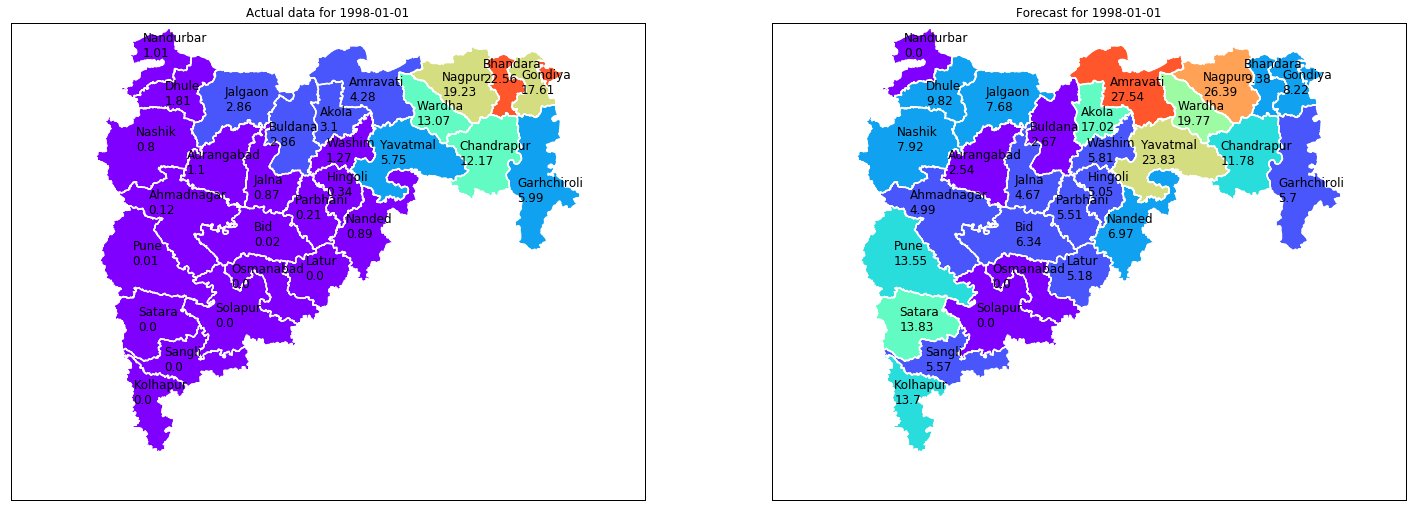

In [161]:
for date in ordered_date_keys:
    
    df = objects_dict[date]
    
    num_colors_actual = 9
    values = df['Actual'].astype(float)
    cm = plt.get_cmap('rainbow')
    a_scheme = [cm(i / num_colors_actual) for i in range(num_colors_actual)]
    bins = np.linspace(values.min(), values.max(), num_colors_actual)
    df['abin'] = np.array(np.digitize(values, bins) - 1)
    df.sort_values('abin', ascending=False).head()

    num_colors_forecast = 9
    values = df['Forecast'].astype(float)
    cm = plt.get_cmap('rainbow')
    f_scheme = [cm(i / num_colors_forecast) for i in range(num_colors_forecast)]
    bins = np.linspace(values.min(), values.max(), num_colors_forecast)
    df['fbin'] = np.array(np.digitize(values, bins) - 1)
    df.sort_values('fbin', ascending=False).head()

    fig = plt.figure(figsize=(25,15))
    ax = fig.add_subplot(121)

    map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
                   llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)
    map.drawmapboundary(fill_color='white')
    map.fillcontinents(color='white',lake_color='white')
    map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)
    
    patches   = []
    facecolor_array = []


    for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
        if(info['NAME_1'] == 'Maharashtra'):
            x, y = zip(*shape) 
            map.plot(x, y, marker=None, color='white')

            district = info['NAME_2']
            if district not in df.index:
                color = '#dddddd'
            else:
                a_color = a_scheme[int(df.ix[district]['abin'])]
                patches.append( Polygon(np.array(shape), True))
                facecolor_array.append(a_color)
                
        else:
            color = '#dddddd'
            
    ax.add_collection(PatchCollection(patches, facecolor= facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    ax.set_title("Actual data for "+str(date))    

    lat = latlon_data['lat'].tolist()
    lon = latlon_data['lon'].tolist()
    label_dist = latlon_data['district'].tolist()
    label_district = latlon_data['district'].tolist()


    X,Y = map(lon,lat)
    ax.scatter(X,Y)
    for i, (x, y) in enumerate(zip(X, Y), start=0):
        actual = df.ix[label_district[i]]['Actual'] 
        ax.annotate(label_dist[i]+"\n"+str(round(actual,2)), (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')
    
    ax = fig.add_subplot(122)

    map = Basemap(projection='lcc',resolution='l', llcrnrlon=72, 
                   llcrnrlat=15,urcrnrlon=82,urcrnrlat=22,lat_0=16,lon_0=75.11)
    map.drawmapboundary(fill_color='white')
    map.fillcontinents(color='white',lake_color='white')
    map.readshapefile('gadm36_IND_shp/gadm36_IND_2', 'gadm36_IND_2', drawbounds = False)
    
    patches   = []
    facecolor_array = []

    for info, shape in zip(map.gadm36_IND_2_info, map.gadm36_IND_2):
        if(info['NAME_1'] == 'Maharashtra'):
            x, y = zip(*shape) 
            map.plot(x, y, marker=None, color='white')

            district = info['NAME_2']
            if district not in df.index:
                color = '#dddddd'
            else:
                f_color = f_scheme[int(df.ix[district]['fbin'])]
                patches.append( Polygon(np.array(shape), True))
                facecolor_array.append(f_color)
        else:
            color = '#dddddd'
            
    ax.add_collection(PatchCollection(patches, facecolor = facecolor_array, edgecolor='w', linewidths=1., zorder=2))
    ax.set_title("Forecast for "+str(date))    

    X,Y = map(lon,lat)
    ax.scatter(X,Y)
    for i, (x, y) in enumerate(zip(X, Y), start=0):
        forecast = df.ix[label_district[i]]['Forecast'] 
        ax.annotate(label_dist[i]+"\n"+str(round(forecast,2)), (x,y), xytext=(0,0), textcoords='offset points',fontsize=12,color='black')
        
    plt.savefig(directory+"/"+date+".png", bbox_inches='tight')
    plt.show()
    
    break

In [154]:
    
#     fig, axes = plt.subplots(1,2,figsize=(18,6))
    
#     axes[0].set_title("Actual")
#     axes[0].set_xticks([])
#     axes[0].set_yticks([])
    
#     axes[1].set_title("Forecast")
#     axes[1].set_xticks([])
#     axes[1].set_yticks([])
